## EIP 1559 Problem Statment
* Outlines mathematical must-dos around EIP 1559 pertaining to **stationarity of basefees**
* Uses Ethereum block simulator (abm1559) created by Ethereum Research Team
    * https://github.com/barnabemonnot/abm1559
    * Can look at this as an addendum to following [notebook](https://github.com/barnabemonnot/abm1559/blob/master/notebooks/stationary1559.ipynb) 
* Understanding stationarity properties of EIP 1559 allows us to optimally configure to ensure stationarity in the basefees under certain mathematical assumptions  

#### References
* https://robjhyndman.com/papers/ar1.pdf
* https://forecasters.org/wp-content/uploads/gravity_forms/7-c6dd08fee7f0065037affb5b74fec20a/2017/07/Regis_Marta_ISF2017.pdf
* https://arxiv.org/pdf/1901.01077.pdf
* https://www.researchgate.net/publication/266729349_Bayesian_estimation_and_unit_root_tests_for_Random_Coefficient_AutoRegressive_models
* https://repository.lib.ncsu.edu/handle/1840.16/4657
* https://hal.archives-ouvertes.fr/hal-00501807/document
* https://kevin-kotze.gitlab.io/tsm/ts-7-note/
* [Stochastic Unit Root Process](http://econweb.rutgers.edu/nswanson/papers/stur5.pdf)
* [FREQUENTIST AND BAYESIAN ANALYSIS OF RANDOM
COEFFICIENT AUTOREGRESSIVE MODELS](https://repository.lib.ncsu.edu/bitstream/handle/1840.16/4657/etd.pdf?sequence=1)
* http://timroughgarden.org/papers/eip1559.pdf

In [1]:
%config InlineBackend.figure_format = 'svg'
import os, sys

sys.path.insert(1, os.path.realpath(os.path.pardir))

from abm1559.utils import constants

from abm1559.txpool import TxPool

from abm1559.users import User1559

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)
from abm1559.simulator import (
    spawn_poisson_demand,
    update_basefee,
)

import pandas as pd
from pomegranate import *
import numpy as np
import json
import matplotlib.pyplot as plt

from itertools import chain, repeat, cycle, islice
import datetime

### EIP 1559 Pricing Mechanism


The basic premise of the new EIP 1559 proposal begins with setting the base fee which increases when the network capacity exceeds the target per-block gas usage, and decreases when the capacity is below the target. The calculation of the updated basefee, $b_{k}$ at the kth block, is as follows:

\begin{equation}
b_{k} = b_{k-1}f_{k-1}
\label{eq:eip1559} \tag{1}
\end{equation}

\begin{equation}
f_{k} = 1 + \frac{\delta_{k}}{c}
\label{eq:fk} \tag{2}
\end{equation}

where $\delta_{k} = demand_{k} - Target Gas Fee$ and $c = Target ~/~ BaseFee Max Change$; for the purpose of this study, we assume $\delta_{k}$ to be a random stationary process. However before we do that, we run abm1559 simulator to show that this is the case, under the assumption that new users are Poison distributed

In [2]:
# EIP1559 constants
eip1559_constants = {
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 50.0,
    "TARGET_GAS_USED": 12500000.0,
    "EIP1559_DECAY_RANGE": 800000,
    "EIP1559_GAS_INCREMENT_AMOUNT": 10.0,
    "INITIAL_BASEFEE": float(1e10),
    "PER_TX_GASLIMIT": 8000000,
}
eip1559_constants["MAX_GAS_EIP1559"] = 2 * eip1559_constants["TARGET_GAS_USED"]

In [3]:
BLOCKS_PER_MINUTE = 4  # assume 15 sec per block for convenience
GAS_TX_COST = 21000

#### Basefee calculation

In [4]:
def calculate_basefee(basefee, fk):
    new_basefee = basefee*fk #+ np.random.normal(0, 0.01)    
    return new_basefee

#### Determine delta (Usage - Target Gas Fee)

In [5]:
def get_delta(demand):
    return map(
        lambda block_consumption:
        block_consumption - eip1559_constants["TARGET_GAS_USED"],
        demand
    )

#### Generate fk

In [6]:
def gen_fk(deltas):   
    
    bf_max = eip1559_constants["BASEFEE_MAX_CHANGE_DENOMINATOR"] 
    tg = eip1559_constants["TARGET_GAS_USED"]    

    fk = np.array([(1 + d / (tg * bf_max)) for d in deltas])
    return fk 

#### Generate basefee estimates

In [7]:
def gen_basefees(fk):

    basefee = eip1559_constants["INITIAL_BASEFEE"]
    basefees = np.zeros(len(fk))
    for k in range(len(fk)):
        prev_basefee = basefee
        new_basefee = calculate_basefee(basefee, fk[k])
        basefee = new_basefee
        basefees[k] = basefee
        #basefees[k] = new_basefee - prev_basefee + float(1e10)
       
    return basefees 

#### Test stationarity

In [8]:
def test_stationary(samp, k):
    result = adfuller(samp)
    test_result = 'NOT STATIONARY' if result[1] > 0.05 else 'STATIONARY'
    print('[SIM {}] ADF Statistic: {} / p-value: {} -> {}'.format(k, result[0], result[1], test_result))

#### Simulate gas demand
* Uses abm1559 simulator
* Makes the following assumptions: 
    * Users are Poisson distributed
    * Every tx consumes 21000 Gas

In [9]:
def simulate_gas_demand(t, demand_scenario, env):
    users = spawn_poisson_demand(t, demand_scenario[t], UserClass)
    txs = []
    for user in users:
        tx = user.transact(env)
        if not tx is None:
            txs.append(tx)

    return GAS_TX_COST*len(txs)  

### Region of strict stationarity and ergodicity for RCA(1)
* [FREQUENTIST AND BAYESIAN ANALYSIS OF RANDOM
COEFFICIENT AUTOREGRESSIVE MODELS](https://repository.lib.ncsu.edu/bitstream/handle/1840.16/4657/etd.pdf?sequence=1)
* Thm 2, pg 23 

In [10]:
num_int = 100
dw = np.linspace(0, 0.9999999, num=num_int)

def pnt_cond(sig2beta,mu2beta):
    
    lmbda = mu2beta/(2*sig2beta)

    def func(w):
        return (1 - np.exp(-lmbda*(1-w**2))) /(1 - w**2)

    def cond(dw):
        integral = sum(list(map(func,dw)))/num_int
        right_side = 0.57721 + numpy.log(2) - 2*integral
        left_side = numpy.log(sig2beta)
        return 1*(left_side < right_side)    
    
    return cond(dw);

### Part A: Simulate Ethereum Blocks
* Purpose of this cell block is educational 
* Helps user understand the various components used to run abm1559 simlation
* Only effective for few thousand blocks, as uses a lot of computational overhead

In [11]:
UserClass = User1559
demand_scenario = [2000 for i in range(200)]

# Instantiate a couple of things
txpool = TxPool()
basefee = constants["INITIAL_BASEFEE"]
chain = Chain()
metrics = []
user_pool = UserPool()

for t in range(len(demand_scenario)):

    # `env` is the "environment" of the simulation
    env = {
            "basefee": basefee,
            "current_block": t,
    }

    # We return a demand drawn from a Poisson distribution.
    # The parameter is given by `demand_scenario[t]`, and can vary
    # over time.
    users = spawn_poisson_demand(t, demand_scenario[t], UserClass)

    # We query each new user with the current basefee value
    # Users either return a transaction or None if they prefer to balk
    decided_txs = user_pool.decide_transactions(users, env)

    # New transactions are added to the transaction pool
    txpool.add_txs(decided_txs)

    # The best valid transactions are taken out of the pool for inclusion
    selected_txs = txpool.select_transactions(env)
    txpool.remove_txs([tx.tx_hash for tx in selected_txs])

    # We create a block with these transactions
    block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

    # The block is added to the chain
    chain.add_block(block)
    
    # A couple of metrics we will use to monitor the simulation
    row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "gas_used": sum([tx.gas_used for tx in block.txs]),
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length,
    }
    metrics.append(row_metrics)

    # Finally, basefee is updated and a new round starts
    basefee = update_basefee(block, basefee)
    
    if (t % 10 == 0): print('{:.1f}% Complete'.format(100*((t)/len(demand_scenario))), end='\r')
        
df = pd.DataFrame(metrics)        

#### Investigate TXs from Ethereum chain simulation

In [12]:
chain_df = chain.export()
chain_df.head(5)

,block_height,tx_index,basefee,tx,start_block,sender,gas_used,tx_hash,gas_premium,max_fee,tip
0,0,0,1.0,1559 Transaction c27acdf9c969f3a3: max_fee 193...,0,0dc8ca38c72df277,21000,c27acdf9c969f3a3,1.0,19.306436,1.0
1,0,1,1.0,1559 Transaction 04fa78b05adb6b15: max_fee 107...,0,235798717d24d543,21000,04fa78b05adb6b15,1.0,10.710051,1.0
2,0,2,1.0,1559 Transaction 21d0d02d981f555b: max_fee 103...,0,b43b34676307da31,21000,21d0d02d981f555b,1.0,10.328270,1.0
3,0,3,1.0,1559 Transaction e2ce96deebb63b06: max_fee 182...,0,94dacc2cb2291569,21000,e2ce96deebb63b06,1.0,18.270157,1.0
4,0,4,1.0,1559 Transaction 642aa5ca3f88ea44: max_fee 143...,0,51e971e788000f51,21000,642aa5ca3f88ea44,1.0,14.326857,1.0


### Part B: Simulate Gas Demand
* For this excercise, we are only interested in basefee simulations
* From Step A can see that running a full ethereum chain simulation using abm1559 consumes a lot of overhead
* We look at simulating just gas demand

In [13]:
N = 1000
UserClass = User1559
env = {"basefee": eip1559_constants['INITIAL_BASEFEE']}

gas_demand = np.zeros(N)
demand_scenario = [2000 for i in range(N)]
for t in range(N):
    gas_demand[t] = simulate_gas_demand(t, demand_scenario, env)
    if (t % 10 == 0): print('{:.1f}%'.format(100*((t)/len(demand_scenario))), end='\r')

#### Use Dickey Fuller Test to check for stationarity 

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(gas_demand)
test_result = 'NOT STATIONARY' if result[1] > 0.05 else 'STATIONARY'
print('[TEST {}] ADF Statistic: {} / p-value: {} -> {}'.format(1, result[0],result[1],test_result)) 

[TEST 1] ADF Statistic: -21.28457378841899 / p-value: 0.0 -> STATIONARY


#### Check for normality

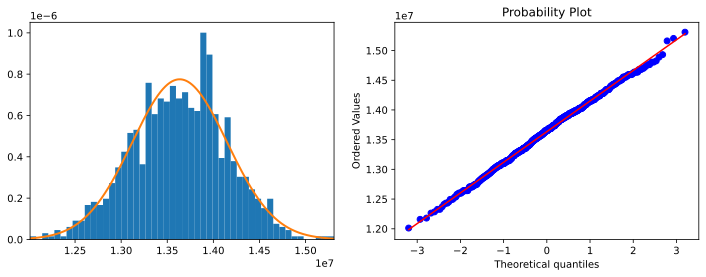

In [15]:
from scipy import stats
import pylab
sim = gas_demand
basefees_sim = sim.flatten()
values = np.linspace(min(basefees_sim), max(basefees_sim), len(basefees_sim))
sample = basefees_sim.reshape(-1,1)
normal_model = NormalDistribution.from_samples(sample)
normal_fit = normal_model.probability(values.flatten())

fig, (dist_ax, ts_ax) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(12, 4))
dist_ax.hist(sample, bins=50, density=True)
dist_ax.plot(values, normal_fit, label="Gamma fit", linewidth=2)
dist_ax.set_xlim(min(values), max(values))

stats.probplot(gas_demand, dist="norm", plot=pylab)
pylab.show()

### Part C: Simulate Basefees
* Using results from above, we assume normal stationary process for gas demand
* Assumption allows us to simulate entire year's worth of base fees for analysis, thus we don't require abm1559 

In [16]:
eip1559_constants["BASEFEE_MAX_CHANGE_DENOMINATOR"] = 50

In [17]:
from scipy.signal import decimate
MINUTES_PER_YEAR = 525600
model_params = json.loads(normal_model.to_json())['parameters']
eip1559_constants["TARGET_GAS_USED"] = model_params[0]

gas_demands = np.random.normal(model_params[0], model_params[1], 4*MINUTES_PER_YEAR)
deltas = list(get_delta(gas_demands))
fk = gen_fk(deltas)
basefees = gen_basefees(fk)
basefees = decimate(basefees, 240, ftype="fir")/1e9
sim = basefees.reshape(-1,1)

for k in range(1,10):
    gas_demands = np.random.normal(model_params[0], model_params[1], 4*MINUTES_PER_YEAR)
    deltas = list(get_delta(gas_demands))
    fk = gen_fk(deltas)
    basefees = gen_basefees(fk)
    basefees = decimate(basefees, 240, ftype="fir")/1e9
    sim = np.hstack((sim,basefees.reshape(-1,1)))
    print('Simulation {}'.format(k), end='\r')

#### Test simulations for stationarity 

In [18]:
from statsmodels.tsa.stattools import adfuller

for k in range(1,10):    
    test_stationary(sim[:,k], k)

median_sim = np.array([np.median(sim[k,:]) for k in range(len(sim))]) 
test_stationary(median_sim, 0)

[SIM 1] ADF Statistic: -1.623554909477762 / p-value: 0.4708660919644082 -> NOT STATIONARY
[SIM 2] ADF Statistic: -1.3265871768478474 / p-value: 0.6169225899533249 -> NOT STATIONARY
[SIM 3] ADF Statistic: -2.3598925129816797 / p-value: 0.15337779408008567 -> NOT STATIONARY
[SIM 4] ADF Statistic: -1.7354911420365378 / p-value: 0.4129253346174331 -> NOT STATIONARY
[SIM 5] ADF Statistic: -2.147698646827313 / p-value: 0.22577203042583976 -> NOT STATIONARY
[SIM 6] ADF Statistic: -2.846125636540784 / p-value: 0.0519811175581885 -> NOT STATIONARY
[SIM 7] ADF Statistic: -1.3560186055565613 / p-value: 0.603170456338467 -> NOT STATIONARY
[SIM 8] ADF Statistic: -1.0178441652735648 / p-value: 0.746700543429571 -> NOT STATIONARY
[SIM 9] ADF Statistic: -0.048162145250665665 / p-value: 0.9543632044214212 -> NOT STATIONARY
[SIM 0] ADF Statistic: -2.2131865405053985 / p-value: 0.20149436156036765 -> NOT STATIONARY


#### Plot simulations

In [19]:
from pymc3.gp.util import plot_gp_dist
start = datetime.datetime(2020, 3, 4, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(hours=i) for i in range(24*365)])
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, sim.transpose(), date_times, palette="YlOrRd")
plt.ylabel("Gas Cost - GWei", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Basefee Gas Cost Simulations: EIP 1559", fontsize=20)
fig.savefig('basefee_simulations.png') ## saved to disk because of memory overhead
plt.close()

### Discussion

For sake of comparison, let's look at stationarity for an AR(1) process: 

Consider a standard first-order auto-regressive process defined by the recursive equation:

\begin{equation}
x_{t} = \mu + \alpha (x_{t-1} -\mu) + \epsilon_{t-1} ~~~~~~~~ \epsilon_{t} \sim IID~N(0,\sigma^2)
\label{eq:ar1} \tag{3}
\end{equation}

The above process is stationary when |𝛼|<1 so that this has a single root 1/𝛼 outside the unit circle.  It can be shown that if 𝜎>0, then this process has the asymptotic stationary distribution:

\begin{equation}
x_{\infty} \sim N(\mu,\frac{\sigma^2}{1-\alpha^2})
\label{eq:x_infinity} \tag{4}
\end{equation}


Considering the (state space like) simularities to the AR(1) process; the question is what are the constraints (if any) that time varying process $\delta_{t}$ must meet to ensure stationary outcomes for the basefees?

In [28]:
t = np.array(range(N))
peak1 = float(1e6)*np.exp(-((t-1000)/100)**2)
peak2 = float(1e6)*np.exp(-((t-2000)/100)**2)
peak3 = float(1e6)*np.exp(-((t-3000)/100)**2)
trend = 10*t

### Part D: Analyze Stationarity via Random Coefficient Autoregressive Models

EIP 1559 (1) fits into the framework of a Random Coefficient Autoregressive (RCA) Model, which  essentially introduces a random coefficients to the AR model in (3). RCA(1) model is given by:

\begin{equation}
x_{k} = \alpha + \beta_{k}x_{k-1} + \epsilon_{k},
\label{eq:rca1} \tag{5}
\end{equation}

where ${\epsilon_{k}}$ is an independent sequence of random variables with 0 mean and variance $\sigma^2 > 0$; ${\beta_{k}}$ is an independent sequence of random variables with mean $\mu_{\beta}$ and variance $\sigma_{\beta}^2$ of the random coefficient $\beta_{k}$, and variance $\sigma^2$ of the error $\epsilon_{k}$. Given (3) and (4) it is obvious that when $\sigma_{\beta}^2 = 0$, the RCA(1) in (5) becomes a AR series, and becomes a random walk when $\mu_{\beta} = 1$ and $\sigma_{\beta}^2 = 0$, hence non-stationary. 

__Theorem 2__ Consider RCA(1) model (5) with ${\beta_{k},\epsilon_{k}}$


In [61]:
basefees[0:100]

array([1.00488416e+10, 1.00784646e+10, 1.00690454e+10, 1.01400577e+10,
       1.01401881e+10, 1.00752564e+10, 1.01049348e+10, 1.01448621e+10,
       1.01853440e+10, 1.02037677e+10, 1.01965871e+10, 1.02076997e+10,
       1.02240373e+10, 1.02246087e+10, 1.02733841e+10, 1.04430116e+10,
       1.04991753e+10, 1.05547009e+10, 1.05602934e+10, 1.06631423e+10,
       1.07108679e+10, 1.07166558e+10, 1.07576721e+10, 1.07628603e+10,
       1.08092194e+10, 1.08983024e+10, 1.10083362e+10, 1.10771068e+10,
       1.11398741e+10, 1.11943904e+10, 1.11781227e+10, 1.12358468e+10,
       1.12749374e+10, 1.12667695e+10, 1.14144922e+10, 1.14774602e+10,
       1.16015573e+10, 1.16673962e+10, 1.17575732e+10, 1.18522511e+10,
       1.18672179e+10, 1.19341864e+10, 1.20844651e+10, 1.22276007e+10,
       1.23842214e+10, 1.26078148e+10, 1.26945624e+10, 1.28922508e+10,
       1.30234935e+10, 1.31562182e+10, 1.33463795e+10, 1.34413970e+10,
       1.34616181e+10, 1.37213557e+10, 1.39475344e+10, 1.40812220e+10,
      

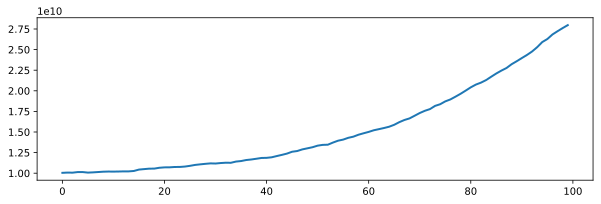

In [60]:
fig = plt.figure(figsize=(10, 3))
plt.plot(basefees[0:100], linewidth=2)

mu: 1.5839079346763718 / sigma 0.3371681732575928 
mu2 + sigma2 = 2.6224467225886317 
Strict Stationarity: False 


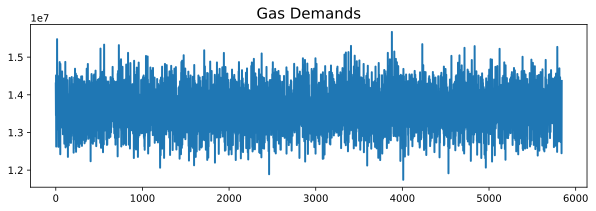

IndexError: index 0 is out of bounds for axis 0 with size 0

In [59]:
import math

eip1559_constants["INITIAL_BASEFEE"] = float(1e10)
eip1559_constants["BASEFEE_MAX_CHANGE_DENOMINATOR"] = 10
eip1559_constants["TARGET_GAS_USED"] = model_params[0]
N = int(4*MINUTES_PER_YEAR/(12*30))

gas_demands = np.random.normal(model_params[0], model_params[1], N) 
deltas = list(get_delta(gas_demands))
fk = gen_fk(deltas) + 0.0002*t

basefees = gen_basefees(fk)
#test_stationary(basefees, 0)

basefees_diff = float(1e10) + (basefees[1:] - basefees[:-1])
#test_stationary(basefees_diff, 0)

sample = fk.reshape(-1,1)
normal_model2 = NormalDistribution.from_samples(sample)
model_params2 = json.loads(normal_model2.to_json())['parameters']

fig = plt.figure(figsize=(10, 3))
plt.plot(gas_demands, linewidth=2)
plt.title("Gas Demands", fontsize=15)

fig = plt.figure(figsize=(10, 3))
plt.plot(basefees, linewidth=2)
plt.title("Gas Costs", fontsize=15)

fig = plt.figure(figsize=(10, 3))
plt.plot(basefees_diff, linewidth=2)
plt.title("Gas Costs - Differenced", fontsize=15)
#plt.ylim(min(basefees_diff),max(basefees_diff))

print('mu: {} / sigma {} '.format(model_params2[0],model_params2[1]))
print('mu2 + sigma2 = {} '.format(model_params2[0]**2+model_params2[1]**2))


sig2beta = model_params2[1]**2
mu2beta = model_params2[0]**2

print('Strict Stationarity: {} '.format(bool(pnt_cond(sig2beta,mu2beta))))

In [22]:
X = np.linspace(-0.05, 4, 1000)
Y = np.linspace(0, 1.75, 1000)
sig2beta, mu2beta = np.meshgrid(X, Y)
Z = pnt_cond(sig2beta,mu2beta)

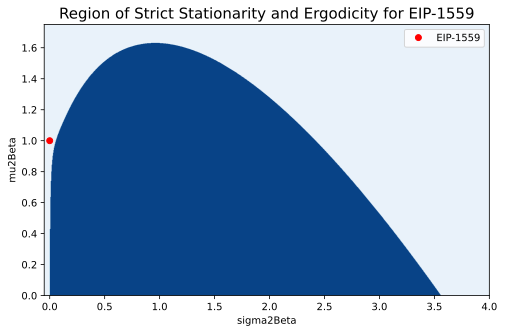

Strict Stationarity: False 


In [23]:
sig2beta = model_params2[1]**2
mu2beta = model_params2[0]**2

fig = plt.figure(figsize=(8, 5))
plt.contourf(X,Y,Z, cmap='Blues')
plt.plot(sig2beta, mu2beta, 'o', color='red', label = 'EIP-1559');
plt.ylabel("mu2Beta")
plt.xlabel("sigma2Beta")
plt.legend(numpoints=1)
plt.title("Region of Strict Stationarity and Ergodicity for EIP-1559", fontsize=15)
fig.savefig('strict_stationarity.png') ## saved to disk because of memory overhead
plt.show()

print('Strict Stationarity: {} '.format(bool(pnt_cond(sig2beta,mu2beta))))